In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from pymc3.gp.util import plot_gp_dist
#import matplotlib.cm as cmap

import numpy as np
import scipy as sp
import pandas as pd
np.random.seed(42)

import theano
import theano.tensor as tt
import pymc3 as pm

# manual implimentation:

In [2]:
# RBF:
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

In [3]:
def conditional(x_new, x, y, params):

    B = exponential_cov(x_new, x, params) # for K**
    C = exponential_cov(x, x, params) # for K
    A = exponential_cov(x_new, x_new, params) # for K*

    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))

    return(mu.squeeze(), sigma.squeeze())

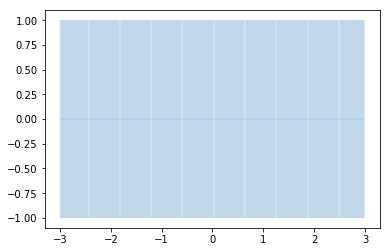

In [4]:
theta = [1, 10] # (hyper) params
sigma0 = exponential_cov(0, 0, theta)
xpts = np.arange(-3, 3, step=0.01) # grid

plt.errorbar(xpts, np.zeros(len(xpts)), yerr=sigma0, capsize=0, alpha = 0.1)

plt.show()

In [5]:
#arbitrary starting point to sample

x = [1.]
y = [np.random.normal(scale=sigma0)]
y

[-0.26993449814542714]

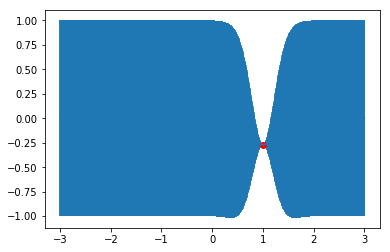

In [6]:
sigma1 = exponential_cov(x, x, theta)
 
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new
 
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, theta, sigma1, y) for i in x_pred]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

plt.show()

In [7]:
# sample one more point:

m, s = conditional([-0.7], x, y, theta)
y2 = np.random.normal(m, s)
y2

0.37943815046187895

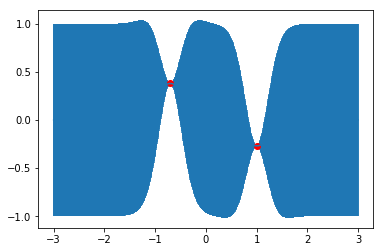

In [8]:
x.append(-0.7)
y.append(y2)
 
sigma2 = exponential_cov(x, x, theta)
predictions = [predict(i, x, exponential_cov, theta, sigma2, y) for i in x_pred]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

plt.show()

In [9]:
# Sampel many points:

x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, theta)
y_more = np.random.multivariate_normal(mu, s)
y_more

array([ 0.15037872, -0.16304757, -0.35545381,  0.37052705,  0.58036922])

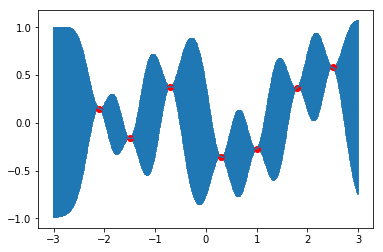

In [10]:
x += x_more
y += y_more.tolist()
 
sigmaNew = exponential_cov(x, x, theta)
predictions = [predict(i, x, exponential_cov, theta, sigmaNew, y) for i in x_pred]
 
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

plt.show()

## PYMC3
https://docs.pymc.io/Gaussian_Processes.html

In [11]:
import pymc3 as pm
import theano.tensor as tt

In [14]:
X = np.array(x).reshape(-1,1)
X.max()

2.5

In [29]:
X = np.array(x).reshape(-1,1)
X_star = np.linspace(X.min()-1,X.max()+1, 100)[:, None]

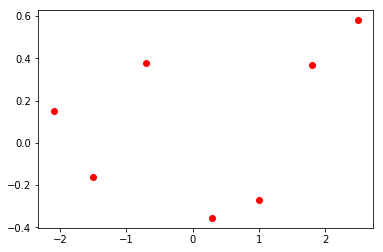

In [30]:
plt.plot(X,y, 'ro')
plt.show()

In [31]:
# the model

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

    mp = pm.find_MAP()

logp = -7.7625, ||grad|| = 0.072186: 100%|██████████| 30/30 [00:00<00:00, 149.88it/s]  


In [32]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["ℓ", "η", "σ"],
              "Value at MAP": [float(mp["ℓ"]), float(mp["η"]), float(mp["σ"])]})

,Parameter,Value at MAP
0,ℓ,0.575505
1,η,0.326239
2,σ,0.154797


In [33]:
# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_star)

In [34]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_ppc([mp], vars=[f_pred], samples=1000)


100%|██████████| 1000/1000 [01:31<00:00, 10.88it/s]


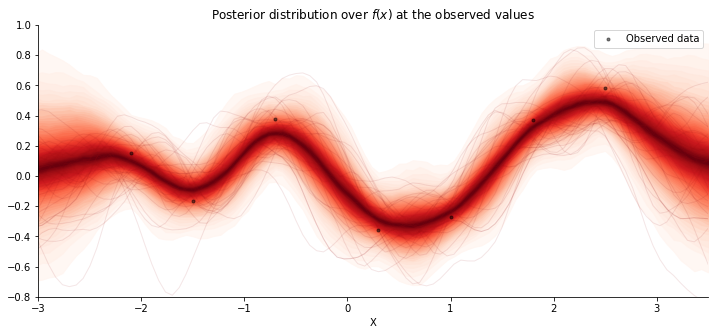

In [38]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples["f_pred"], X_star)

# plot the data and the true latent function
#plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13])
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend()

plt.ylim(-0.8,1)
plt.xlim(-3,3.5)
sns.despine()

plt.show()

But f_pred is the noiseless function $f_*$ not $f_* + noise$, which is what we actually observe:

$$y = f(x) + \epsilon$$

The conditional method of gp.Marginal contains the flag pred_noise whose default value is False. To draw from the posterior predictive distribution, we simply set this flag to True.

In [39]:
with model:
    y_pred = gp.conditional("y_pred", X_star, pred_noise=True)
    y_samples = pm.sample_ppc([mp], vars=[y_pred], samples=1000)

100%|██████████| 1000/1000 [01:00<00:00, 16.50it/s]


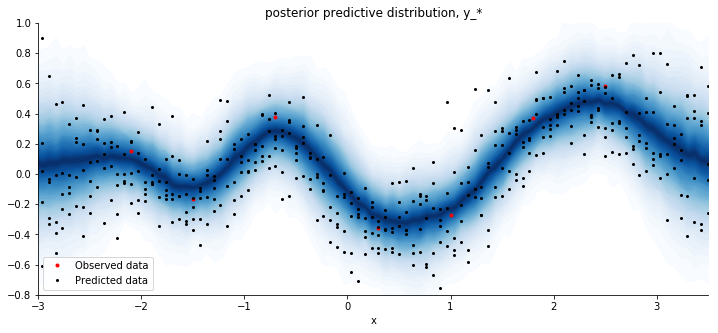

In [60]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
plot_gp_dist(ax, y_samples["y_pred"], X_star, plot_samples=False, palette="Blues")


# plot original data and true function
plt.plot(X, y, 'ro', ms=3, alpha=1.0) #, label="observed data")
#plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")

# overlay a scatter of one draw of 5 random points from the
#  posterior predictive distribution
plt.plot(X_star, y_samples["y_pred"][800:805, :].T, "ok", ms=2 ) #, label="Predicted data")

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("posterior predictive distribution, y_*")
plt.legend(["Observed data", "Predicted data"])

plt.ylim(-0.8,1)
plt.xlim(-3,3.5)
sns.despine()

plt.show()

# SKlearn

In [81]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [84]:
#kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=0.01)
kernel = RBF()

In [85]:
gp = gaussian_process.GaussianProcessRegressor(kernel = kernel)
gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [86]:
y_pred, sigma = gp.predict(X_star, return_std=True)

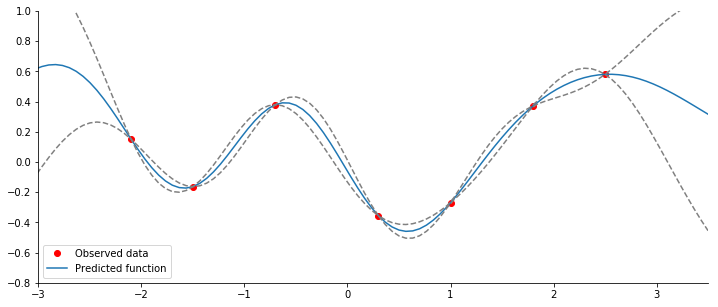

In [93]:
fig = plt.figure(figsize=(12,5))


plt.plot(X,y,'ro', alpha = 1)
plt.plot(X_star,y_pred, '-')

plt.plot(X_star,y_pred + sigma, '--', X_star,y_pred - sigma, '--' , color= 'gray')

plt.ylim(-0.8,1)
plt.xlim(-3,3.5)
sns.despine()

plt.legend(["Observed data", "Predicted function"])

plt.show()

Mega hurtigt og mega fint, men kan jeg få komponenter ud her? Kan jeg lave heirarki? nok ikke....